## Work
### 請結合前面的知識與程式碼，比較不同的 regularization 的組合對訓練的結果與影響：如 dropout, regularizers, batch-normalization 等

In [1]:
import os
import keras
import itertools
# Disable GPU
os.environ["CUDA_VISIBLE_DEVICES"] = "0"

Using TensorFlow backend.


In [2]:
train, test = keras.datasets.cifar10.load_data()

170500096/170498071 [==============================] - 11s 0us/step


In [0]:
## 資料前處理
def preproc_x(x, flatten=True):
    x = x / 255.
    if flatten:
        x = x.reshape((len(x), -1))
    return x

def preproc_y(y, num_classes=10):
    if y.shape[-1] == 1:
        y = keras.utils.to_categorical(y, num_classes)
    return y    

In [0]:
x_train, y_train = train
x_test, y_test = test

# Preproc the inputs
x_train = preproc_x(x_train)
x_test = preproc_x(x_test)

# Preprc the outputs
y_train = preproc_y(y_train)
y_test = preproc_y(y_test)

In [0]:
from keras.layers import Dropout
def build_mlp(input_shape, output_units=10, num_neurons=[512, 256, 128], dropout_ratio = 0):
    input_layer = keras.layers.Input(input_shape)
    
    for i, n_units in enumerate(num_neurons):
        if i == 0:
            x = keras.layers.Dense(units=n_units, activation="relu", name="hidden_layer"+str(i+1))(input_layer)
        else:
            x = keras.layers.Dense(units=n_units, activation="relu", name="hidden_layer"+str(i+1))(x)  
        if dropout_ratio > 0:
          x = Dropout(dropout_ratio)(x)
        
    out = keras.layers.Dense(units=output_units, activation="softmax", name="output")(x)
    
    model = keras.models.Model(inputs=[input_layer], outputs=[out])
    return model

In [0]:
"""Code Here
設定超參數
"""
#LEARNING_RATE = [1e-1, 1e-2, 1e-3, 1e-4, 1e-5]
LEARNING_RATE = 1e-3
EPOCHS = 50
BATCH_NORMALIZTION_SIZE = [128, 256]
MOMENTUM = 0.95
OPTS = ['SGD' ,'RMSprop', 'AdaGrad', 'Adam']
DROPOUT_RATIOS = [0.15, 0.25, 0.35]


In [17]:
results = {}
"""Code Here
撰寫你的訓練流程並將結果用 dictionary 紀錄
"""

for (opt ,dropout_ratio, batch_size) in itertools.product(OPTS, DROPOUT_RATIOS, BATCH_NORMALIZTION_SIZE):
    lr = LEARNING_RATE
    keras.backend.clear_session() # 把舊的 Graph 清掉0
    print("Experiment with opt = %s dropbuy_ratio = %.2f BN_size = %i" % (opt, dropout_ratio, batch_size))
    model = build_mlp(input_shape=x_train.shape[1:], dropout_ratio=dropout_ratio)
    model.summary()
    
    if opt == 'SGD':
      optimizer = keras.optimizers.SGD(lr=lr, nesterov=True, momentum=MOMENTUM)
    elif opt == 'RMSprop':
      optimizer = keras.optimizers.RMSprop(lr=lr, epsilon=None, decay=0.0)   
    elif opt == 'AdaGrad':
      optimizer = keras.optimizers.Adagrad(lr=lr, epsilon=None, decay=0.0)
    elif opt == 'Adam':
      optimizer = keras.optimizers.Adam(lr=lr, beta_1=0.9, beta_2=0.999, epsilon=None, decay=0.0, amsgrad=False)
    else :
      optimizer = None
      
    model.compile(loss="categorical_crossentropy", metrics=["accuracy"], optimizer=optimizer)

    model.fit(x_train, y_train, 
              epochs=EPOCHS, 
              batch_size=batch_size, 
              validation_data=(x_test, y_test), 
              shuffle=True)
    
    # Collect results
    train_loss = model.history.history["loss"]
    valid_loss = model.history.history["val_loss"]
    train_acc = model.history.history["acc"]
    valid_acc = model.history.history["val_acc"]
    
    exp_name_tag = "Exp-opt-%s-drp-%.2f-BN-%i" % ( (opt, dropout_ratio, batch_size))
    results[exp_name_tag] = {'train-loss': train_loss,
                             'valid-loss': valid_loss,
                             'train-acc': train_acc,
                             'valid-acc': valid_acc}

Experiment with opt = SGD dropbuy_ratio = 0.15 BN_size = 128
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 3072)              0         
_________________________________________________________________
hidden_layer1 (Dense)        (None, 512)               1573376   
_________________________________________________________________
dropout_1 (Dropout)          (None, 512)               0         
_________________________________________________________________
hidden_layer2 (Dense)        (None, 256)               131328    
_________________________________________________________________
dropout_2 (Dropout)          (None, 256)               0         
_________________________________________________________________
hidden_layer3 (Dense)        (None, 128)               32896     
_________________________________________________________________
dropout_3 (Drop

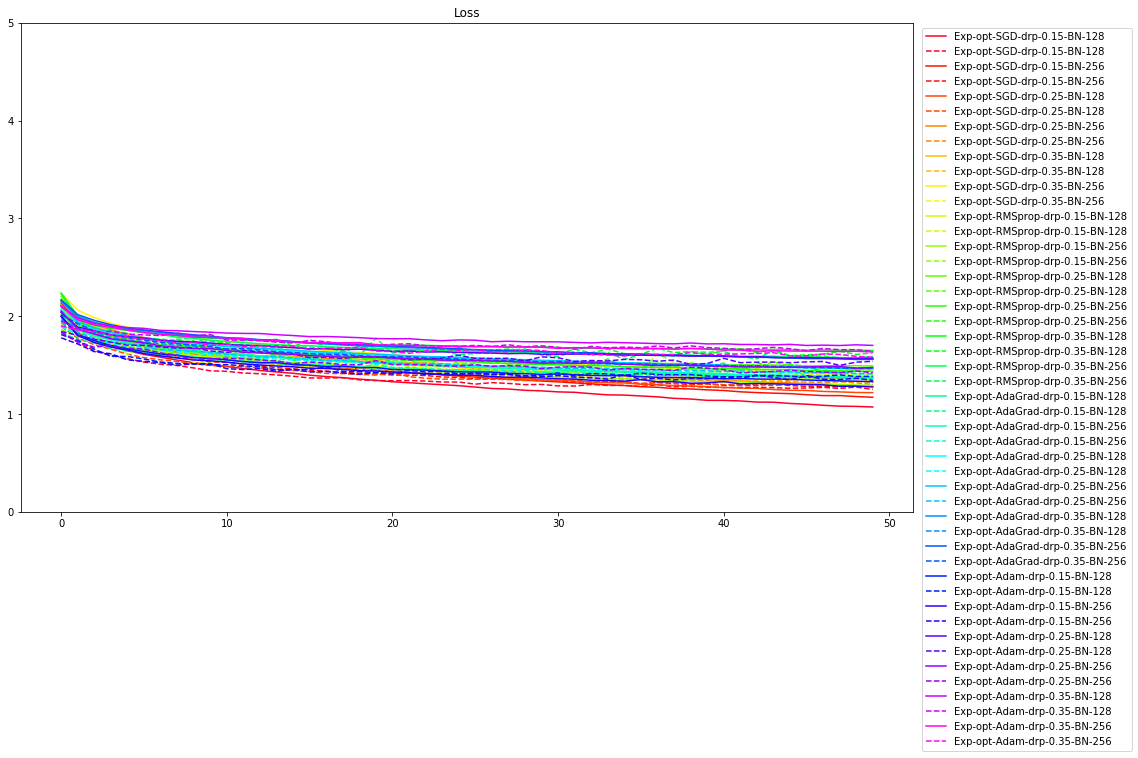

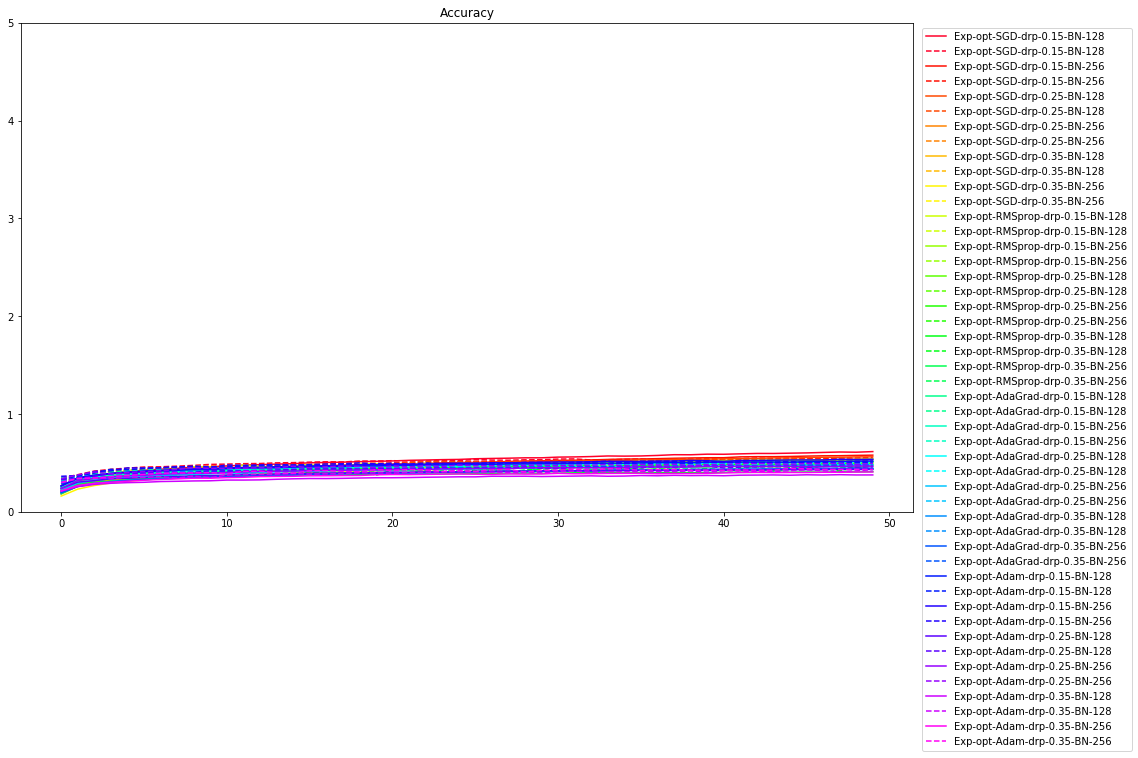

In [52]:
import matplotlib.pyplot as plt
%matplotlib inline


NUM_COLORS = len(results.keys())
cm = plt.get_cmap('gist_rainbow')
color_bar = [cm(1.*i/NUM_COLORS) for i in range(NUM_COLORS)]

fig = plt.figure(figsize=(16,9))
ax = fig.add_subplot(111) 
for i, cond in enumerate(results.keys()):
    plt.plot(range(len(results[cond]['train-loss'])),results[cond]['train-loss'], '-', label=cond, color=color_bar[i])
    plt.plot(range(len(results[cond]['valid-loss'])),results[cond]['valid-loss'], '--', label=cond, color=color_bar[i])
plt.title("Loss")
plt.ylim([0, 5])
leg = plt.legend( loc = 'best')
bb = leg.get_bbox_to_anchor().inverse_transformed(ax.transAxes)

# Change to location of the legend. 
xOffset = 0.25
bb.x0 += xOffset
bb.x1 += xOffset
leg.set_bbox_to_anchor(bb, transform = ax.transAxes)
plt.show()

fig = plt.figure(figsize=(16,9))
ax = fig.add_subplot(111)
for i, cond in enumerate(results.keys()):
    plt.plot(range(len(results[cond]['train-acc'])),results[cond]['train-acc'], '-', label=cond, color=color_bar[i])
    plt.plot(range(len(results[cond]['valid-acc'])),results[cond]['valid-acc'], '--', label=cond, color=color_bar[i])
plt.title("Accuracy")
plt.ylim([0, 5])
leg = plt.legend( loc = 'best')
bb = leg.get_bbox_to_anchor().inverse_transformed(ax.transAxes)
xOffset = 0.25
bb.x0 += xOffset
bb.x1 += xOffset
leg.set_bbox_to_anchor(bb, transform = ax.transAxes)
plt.show()